In [1]:
## QTL analysis
## Bring in needed mods
import pandas as pd, numpy as np, statsmodels.api as sm
from statsmodels.formula.api import ols
from matplotlib import pyplot as plt
%matplotlib inline

## Bring in needed ftn for QTL analysis
from scipy.stats import kruskal

## Write function for QTL analysis
def crypto_kruskal(site,pheno):
    """
    For the data from the C. deneoformans cross, a non-parametric ANOVA.
    Here we are looking for differences between the median phenotypes of group 0 and 1. 
    """
    pheno = pheno.dropna();assert len(pheno) > 0;
    site = site[pheno.dropna().index.tolist()];
    assert len(site) == len(pheno)
    try:
        pval = -np.log10(kruskal(np.array(pheno)[np.array(site) == 0],
                                        np.array(pheno)[np.array(site) == 1],
                                        nan_policy='omit')[1])
    except ValueError:
        pval = np.nan
    return pval

In [2]:
## Set path to genotype data
geno_path = '../FILES/CDx-ill-SNP-INDEL-df-104-blocked.csv'

In [3]:
## Bring in genotype data
bgeno = pd.read_csv(geno_path)

In [4]:
nr = 'SS-B593'

In [5]:
nr in bgeno.columns.tolist()

False

In [1]:
from sklearn.model_selection import GridSearchCV

In [2]:
?GridSearchCV

In [5]:
bgeno.head()

,Chrom,Pos,Qual,Callrate,Ref,Alt,Altlen,Dp,Type,Vcfix,...,SS-B598,SS-B565,SS-B600,SS-B574,SS-B872_cor,SS-B873_cor,SS-B360,SS-B397,SS-B564,SS-B382
0,Chr01,5016,104492.0,1.0,C,A,1,6510,snp,289,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,Chr01,5299,112647.0,1.0,T,C,1,9711,snp,293,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,Chr01,5464,112658.0,1.0,T,C,1,9375,snp,294,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,Chr01,6120,109003.0,1.0,T,C,1,9311,snp,311,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,Chr01,6166,114638.0,1.0,G,A,1,9269,snp,312,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [6]:
## Check its shape
bgeno.shape

(92103, 125)

In [8]:
unique_blocks = bgeno.Block.unique()

In [9]:
len(unique_blocks)

3108

In [10]:
## Gather a list of the chromosomes
chrlist = sorted(bgeno.Chrom.unique());

In [11]:
## make sure there are 14
assert len(chrlist) >= 14

In [12]:
## Chrom should be the edge of the info in geno df
bgcol = bgeno.columns.tolist()
## gather bgeno info columsn
bginfoix = bgcol.index('Block')+1
## Gather info from bgeno
bgeno_info = bgcol[:bginfoix]
## Gather strain names
bgeno_strains = bgcol[bginfoix:]
## How many?
len(bgeno_strains)

104

In [130]:
codf = pd.concat([bgeno[(bgeno.Chrom==chrom)][
    bgeno_strains].diff(axis=0).abs().sum() 
                  for chrom in chrlist],axis=1)
codf.columns= chrlist

In [131]:
parentals = ['XL280a','XL280alpha','SS-A837']

In [132]:
assert codf.T[parentals].sum().sum() == 0

In [133]:
codf.drop(parentals,inplace=True,axis=0)

In [134]:
codf.shape

(101, 14)

In [135]:
to_test_ix = [bgeno[(bgeno.Block == b)].index.tolist()[0] 
              for b in unique_blocks]

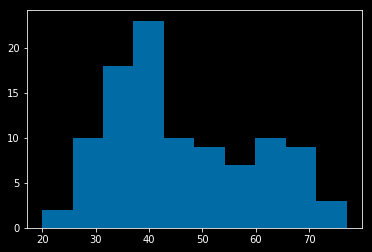

In [137]:
plt.hist(codf.sum(axis=1));

In [326]:
mean_pval = bgeno.iloc[to_test_ix,bginfoix:].apply(
             crypto_kruskal,axis=1,args=[codf.mean(axis=1)])

In [327]:
pvaldf_m = pd.concat([bgeno.loc[to_test_ix,'Block']]+[mean_pval],axis=1)

In [138]:
temp_pval = bgeno.iloc[to_test_ix,bginfoix:].apply(
             crypto_kruskal,axis=1,args=[codf.sum(axis=1)])

In [139]:
## concat dataframes
pvaldf = pd.concat([bgeno.loc[to_test_ix,'Block']]+[temp_pval],axis=1)

In [140]:
pvaldf.columns = ['Block'] + ['Co']

In [141]:
pvaldf.head()

,Block,Co
0,0,0.953949
232,1,0.869017
249,2,0.168703
252,3,0.400628
254,4,0.291628


In [328]:
pvaldf_m.columns = ['Block'] + ['mCo']

In [329]:
pvaldf_m.head()

,Block,mCo
0,0,0.953949
232,1,0.869017
249,2,0.168703
252,3,0.400628
254,4,0.291628


In [142]:
bgenop = bgeno.merge(pvaldf,on=['Block'])

In [331]:
bgenopm = bgenop.merge(pvaldf_m,on=['Block'])

In [332]:
bgenopm.head()

,Chrom,Pos,Qual,Callrate,Ref,Alt,Altlen,Dp,Type,Vcfix,...,SS-B600,SS-B574,SS-B872_cor,SS-B873_cor,SS-B360,SS-B397,SS-B564,SS-B382,Co_y,mCo
0,Chr01,5016,104492.0,1.0,C,A,1,6510,snp,289,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.953949,0.953949
1,Chr01,5299,112647.0,1.0,T,C,1,9711,snp,293,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.953949,0.953949
2,Chr01,5464,112658.0,1.0,T,C,1,9375,snp,294,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.953949,0.953949
3,Chr01,6120,109003.0,1.0,T,C,1,9311,snp,311,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.953949,0.953949
4,Chr01,6166,114638.0,1.0,G,A,1,9269,snp,312,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.953949,0.953949


In [144]:
clens = [bgenop[(bgenop.Chrom==c)]['Pos'].max() for c in chrlist]

In [145]:
cumpos = [0] + list(np.cumsum(clens[:-1]))

In [146]:
plt.style.use(['dark_background','tableau-colorblind10'])

In [147]:
## Set mid points
chrom_midpts = 0.5 * np.sum(np.array([a 
                    for a in zip([0]+list(np.cumsum(clens)),
                            np.cumsum(clens))]),axis=1)

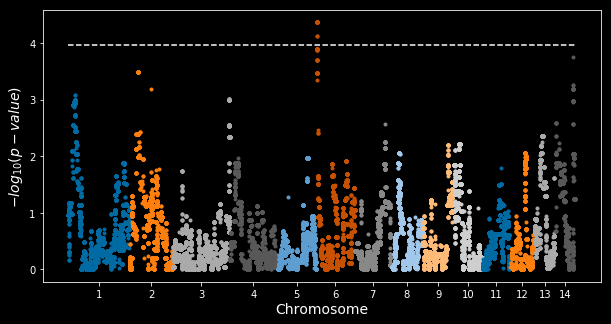

In [437]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
plt.hlines(3.96,0,
           bgenop[(bgenop.Chrom=='Chr14')].Pos.max()+cumpos[-1],
           color='w',linestyle='--')
for c, ch in enumerate(chrlist):
    temp = bgenopm[(bgenopm.Chrom==ch)]
    plt.plot(temp.Pos+cumpos[c],temp.mCo,'.');
ax.set_xticks(chrom_midpts);
ax.set_xticklabels([str(i) for i in range(1, len(clens)+1)]);
plt.xlabel('Chromosome',fontsize=14);
plt.ylabel('$-log_{10}(p-value)$',fontsize=14);
fig.savefig('../FIGURES/manhattan_crossover.png',
            bbox_inches='tight',dpi=100);

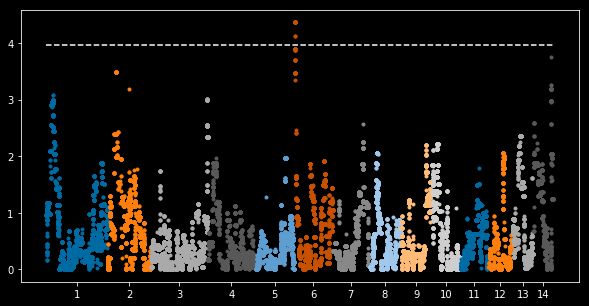

In [188]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
plt.hlines(3.96,0,
           bgenop[(bgenop.Chrom=='Chr14')].Pos.max()+cumpos[-1],
           color='w',linestyle='--')
for c, ch in enumerate(chrlist):
    temp = bgenop[(bgenop.Chrom==ch)]
    plt.plot(temp.Pos+cumpos[c],temp.Co_y,'.');
ax.set_xticks(chrom_midpts);
ax.set_xticklabels([str(i) for i in range(1, len(clens)+1)]);

In [248]:
bgenop['Co_y'].idxmax()

44347

In [249]:
bgenop[(bgenop.Co_y>=3.96)]

,Chrom,Pos,Qual,Callrate,Ref,Alt,Altlen,Dp,Type,Vcfix,...,SS-B565,SS-B600,SS-B574,SS-B872_cor,SS-B873_cor,SS-B360,SS-B397,SS-B564,SS-B382,Co_y
44343,Chr06,38333,98418.6,1.0,C,G,1,7484,snp,1279,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,4.115795
44344,Chr06,38454,103059.0,1.0,T,G,1,7705,snp,1281,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,4.115795
44347,Chr06,39295,97849.4,1.0,A,G,1,7454,snp,1305,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,4.363825
44350,Chr06,40106,95558.2,1.0,C,T,1,7352,snp,1336,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,4.363825
44351,Chr06,40198,104073.0,1.0,C,G,1,8085,snp,1337,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,4.363825
44352,Chr06,40356,74238.4,1.0,GTTTG,GTTTTT,1,6993,indel,1340,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,4.363825
44353,Chr06,40367,82350.7,1.0,A,G,1,7316,snp,1341,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,4.363825
44354,Chr06,40376,78926.2,1.0,AGC,AA,1,7285,indel,1342,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,4.363825
44355,Chr06,40458,93768.7,1.0,ACCG,GCCA,1,7411,indel,1344,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,4.363825
44356,Chr06,40579,89728.8,1.0,TCCTA,CACTG,1,7309,indel,1347,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,4.363825


In [254]:
gff_xl = pd.read_csv('../FILES/xl280genome.gff3.csv',index_col=0)

In [271]:
gff_res = pd.read_csv('../FILES/XL280_431_gene_analysis.csv')

In [274]:
gff_res[(gff_res.gene=='CNF00130')]

,chrom,gene,mod_three,length_check,nonsense,missense
2848,Chr06,CNF00130,1,1,0,2


In [276]:
41568-39223

2345

In [283]:
gff_xl[(gff_xl.gene=='CNF00130') & 
       (gff_xl.type=='CDS')][['start','end']].diff(axis=1).sum()['end']%3

0.0

In [258]:
gff_xl[(gff_xl.contig=='Chr06') & (gff_xl.start>= 38332) & (gff_xl.end<=40900)]

,type,gene,start,end,strand,contig,phase,attribute,description,id
31854,exon,CNF00130,39223,39372,+,Chr06,.,ID=exon_CNF00130-E1;Parent=CNF00130-t26_1,NaN,exon_CNF00130-E1
31855,exon,CNF00130,39424,39679,+,Chr06,.,ID=exon_CNF00130-E2;Parent=CNF00130-t26_1,NaN,exon_CNF00130-E2
31856,exon,CNF00130,39730,39856,+,Chr06,.,ID=exon_CNF00130-E3;Parent=CNF00130-t26_1,NaN,exon_CNF00130-E3
31857,exon,CNF00130,39896,40060,+,Chr06,.,ID=exon_CNF00130-E4;Parent=CNF00130-t26_1,NaN,exon_CNF00130-E4
31858,exon,CNF00130,40109,40346,+,Chr06,.,ID=exon_CNF00130-E5;Parent=CNF00130-t26_1,NaN,exon_CNF00130-E5
31859,exon,CNF00130,40396,40523,+,Chr06,.,ID=exon_CNF00130-E6;Parent=CNF00130-t26_1,NaN,exon_CNF00130-E6
31860,exon,CNF00130,40564,40810,+,Chr06,.,ID=exon_CNF00130-E7;Parent=CNF00130-t26_1,NaN,exon_CNF00130-E7
31864,CDS,CNF00130,39253,39372,+,Chr06,0,ID=CNF00130-t26_1-p1-CDS1;Parent=CNF00130-t26_...,NaN,CNF00130-t26_1-p1-CDS1
31865,CDS,CNF00130,39424,39679,+,Chr06,1,ID=CNF00130-t26_1-p1-CDS2;Parent=CNF00130-t26_...,NaN,CNF00130-t26_1-p1-CDS2
31866,CDS,CNF00130,39730,39856,+,Chr06,1,ID=CNF00130-t26_1-p1-CDS3;Parent=CNF00130-t26_...,NaN,CNF00130-t26_1-p1-CDS3


In [285]:
codf_qtlsite = pd.DataFrame([bgenop.T[bgenop['Co_y'].idxmax()].T[codf.index],codf.sum(axis=1)]).T

In [286]:
codf_qtlsite.columns = ['Allele','Co']

In [287]:
import seaborn as sns

In [291]:
codf_qtlsite.groupby(['Allele']).agg({'Co':[np.mean]}).diff()

,Co
,mean
Allele,
0.0,NaN
1.0,11.737398


In [288]:
codf_qtlsite.groupby(['Allele']).agg({'Co':[np.mean]})

,Co
,mean
Allele,
0.0,41.433333
1.0,53.170732


In [298]:
crossinfo = pd.read_csv('../FILES/OLD/OCT2018/CDx_PB_Ill_Sample_Info.csv',index_col=0)

In [299]:
crossinfo.head()

,PB-name,Code,PB-index,Ill-index,Ill-name,Aneuploidy
Strain,,,,,,
SS-A837,SS-A837_CGCTCAT-GGCTCTG-CR_Canu_polished_JRW-124,3,0,25,SS-A837-126,0
SS-B358,RBB31_SS-B358_TCCGGAG-CAGGACG-CR_Canu_polished...,2,1,40,SS-B358-24,0
SS-B565,SHSB3_05-SS-B565_CTGAAGC-AGGCGAA-CR_Canu_polis...,2,2,115,SS-B565-66,0
SS-B368,RBB35_SS-B368_CGCTCAT-CCTATCC-CR_Canu_polished...,2,3,27,SS-B368-28,0
SS-C030,RBB132_SS-C030_GTTTCG-CR_Canu_polished_JRW-5,1,4,73,SS-C030-5,0


In [300]:
codf_qtlsite['Code'] = crossinfo.T[codf_qtlsite.index].T['Code']

In [390]:
codf_qtlsite['Cross'] = ['431 x Xl280a' if a is 1 else '431 x Xl280'  
                         for a in codf_qtlsite.Code.tolist()  ]

In [386]:
codf.mean(axis=1).head()

SS-B407        1.785714
SS-B316        2.428571
SS-B898_cor    4.285714
SS-B369        2.642857
SS-B997        2.785714
dtype: float64

In [387]:
codf_qtlsite['mCo'] = codf_qtlsite['Co']/14

In [388]:
codf_qtlsite.head()

,Allele,Co,Code,Cross,mCo
SS-B407,0.0,25.0,2,431 X xl280,1.785714
SS-B316,0.0,34.0,2,431 X xl280,2.428571
SS-B898_cor,0.0,60.0,1,431 x Xl280a,4.285714
SS-B369,0.0,37.0,2,431 X xl280,2.642857
SS-B997,1.0,39.0,1,431 x Xl280a,2.785714


In [434]:
codf_qtlsite.groupby(['Allele']).agg({'mCo':[np.mean]}).diff()

,mCo
,mean
Allele,
0.0,NaN
1.0,0.838386


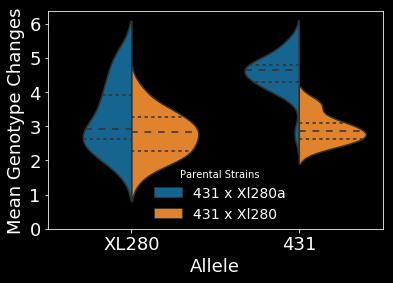

In [431]:
sns.violinplot(x='Allele',y='mCo',hue='Cross',split=True,data=codf_qtlsite,
           hue_order=['431 x Xl280a','431 x Xl280'],
           x_jitter=0.25,fit_reg=False,inner="quartile");
plt.legend(title="Parental Strains",
           fontsize=14,loc=(.3,.0091),frameon=False)
plt.xticks([0,1],['XL280','431'],fontsize=18);
plt.xlabel('Allele',fontsize=18);
plt.ylabel('Mean Genotype Changes',fontsize=18);
plt.yticks(np.arange(0,7),fontsize=18);
plt.savefig('../FIGURES/crossovers_qtl.png',
            bbox_inches='tight',dpi=100);

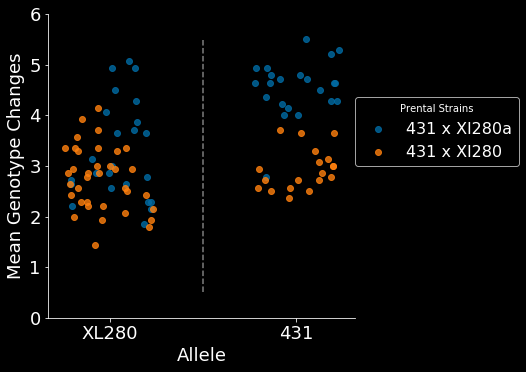

In [416]:
sns.lmplot(x='Allele',y='mCo',hue='Cross',data=codf_qtlsite,
           hue_order=['431 x Xl280a','431 x Xl280'],
           x_jitter=0.25,fit_reg=False,legend_out=False);
plt.legend(title="Prental Strains",fontsize=16,loc=(1,.5))
plt.vlines(0.5,.5,5.5,linestyle='--',color='w',alpha=0.5)
plt.xticks([0,1],['XL280','431'],fontsize=18);
plt.xlabel('Allele',fontsize=18);
plt.ylabel('Mean Genotype Changes',fontsize=18);
plt.yticks(np.arange(0,7),fontsize=18);
plt.savefig('../FIGURES/crossovers_qtl.png',
            bbox_inches='tight',dpi=100);

In [159]:
tempdist = np.array(sorted([t.max() for t in perm_pval]))

In [160]:
len(tempdist)

703

In [186]:
np.percentile(sorted(max_pval),95)

3.9567780154445185

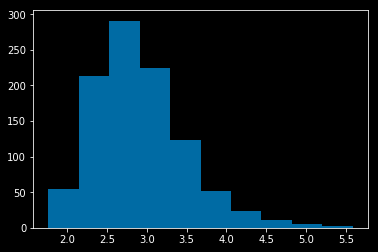

In [187]:
plt.hist(max_pval);

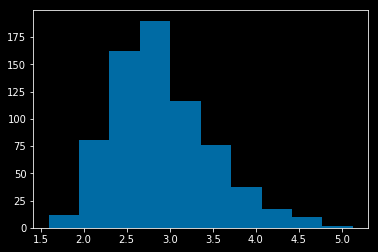

In [156]:
plt.hist(tempdist);

co = codf.sum(axis=1).values
strain_ix = codf.index.tolist()
max_pval = []
i = 0
while len(max_pval) < 1000:
    np.random.shuffle(co)
    cosum = pd.Series(co,index= strain_ix)
    temppval = bgeno.iloc[to_test_ix,bginfoix:].apply(
        crypto_kruskal,axis=1,args=[cosum])
    max_pval.append(temppval.max())
    if len(max_pval)/1000.0 in [0.25,0.50,0.75]:
        print(len(max_pval)/1000.0)

In [181]:
len(max_pval)

1000

In [184]:
pd.DataFrame(max_pval).to_csv('../FILES/cross_over_qtl_perm_pval.csv')

In [50]:
## Make the saving path
savepath = '../FILES/'+file_path.split('/')[-1].split('.csv')[0]+'_co_pvalues.csv'

NameError: name 'file_path' is not defined

In [58]:
## Print the save path
savepath

'../FILES/Tecan_qtlruns_Dec172018_curated_baselined_gompertz_var_pvalues.csv'

In [59]:
## Save data
bgenop.to_csv(savepath)

In [61]:
chrlist = bgenop.Chrom.unique()
clens = [bgenop[(bgenop.Chrom==ch)].Pos.max() for ch in chrlist]

In [62]:
cumpos = [0] + list(np.cumsum(clens[:-1]))

In [63]:
## Set mid points
chrom_midpts = 0.5 * np.sum(np.array([a 
                    for a in zip([0]+list(np.cumsum(clens)),
                            np.cumsum(clens))]),axis=1)

In [67]:
plt.style.use(['dark_background','tableau-colorblind10'])

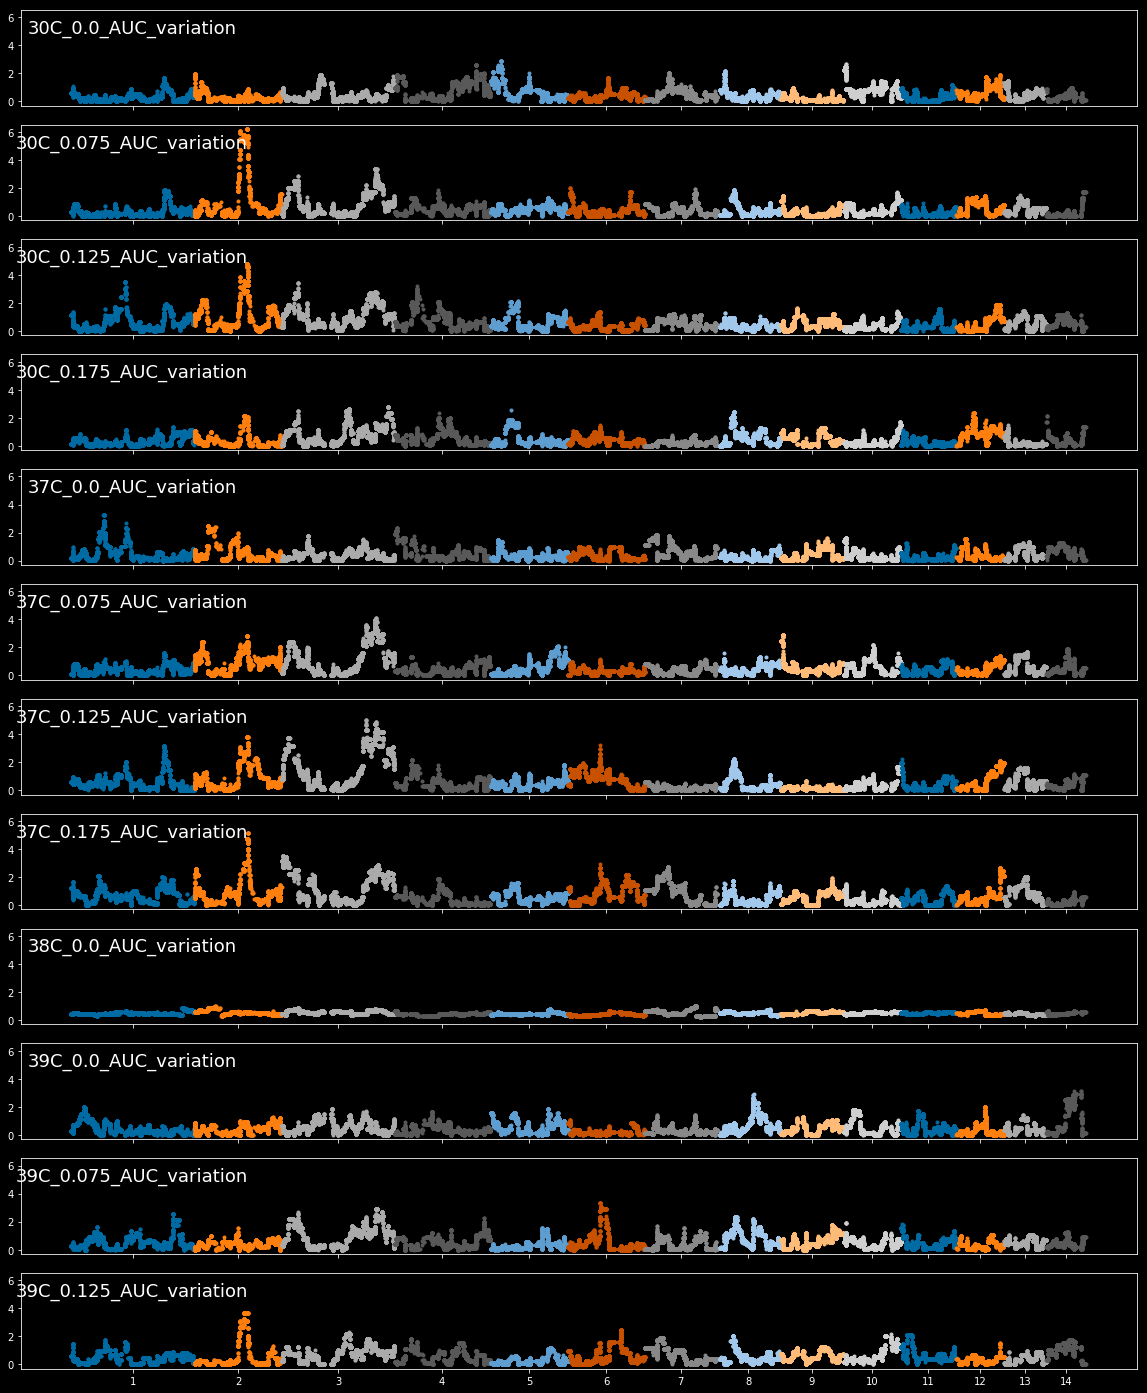

In [68]:
fig, ax = plt.subplots(len(pval_cols),1,figsize=(20,25),
                       sharex=True,sharey=True)
for p,pheno in enumerate(pval_cols):
    plt.sca(ax[p]);
    plt.title(pheno,x=0.1,y=0.7,fontsize=18)
    for c,ch in enumerate(chrlist):
        temp = bgenop[(bgenop.Chrom==ch)][['Pos',pheno]]
        plt.plot(temp.Pos.values+cumpos[c],temp[pheno].values,'.')
ax[-1].set_xticks(chrom_midpts);
ax[-1].set_xticklabels([str(i) for i in range(1, len(clens)+1)]);

In [ ]:
## Variance explained! 
## First approximation
phenotypes.shape

In [ ]:
i = 4
max_con = pvaldf[pvaldf.columns.tolist()[10:]].max().index[i]
max_pval = pvaldf[pvaldf.columns.tolist()[10:]].max()[i]

In [ ]:
max_con

In [ ]:
max_pval_ix = pvaldf[pvaldf[max_con] == max_pval].index
max_pval_ix

In [ ]:
bgeno.loc[max_pval_ix]

In [ ]:
max_genos = bgeno.loc[[max_pval_ix[0]]][bgeno.columns.tolist()[10:]]
max_genos.index = ['geno']

In [ ]:
max_phenos = phenotypes[(phenotypes.temp==int(max_con.split('C_')[0])) & 
           (phenotypes.amphB==float(max_con.split('C_')[-1]))]

In [ ]:
max_geno_pheno_df = pd.concat([max_phenos,max_genos.T],axis=1,sort=True)

In [ ]:
#plt.hist(np.log(max_geno_pheno_df.median_AUC.values));

In [ ]:
#max_geno_pheno_df['log_auc'] = np.log(max_geno_pheno_df.median_AUC)

In [ ]:
max_geno_pheno_df.tail()

In [ ]:
model = ols('median_AUC ~ C(geno)',data=max_geno_pheno_df)

In [ ]:
res = model.fit()

In [ ]:
-np.log10(res.pvalues)

In [ ]:
res.summary()

In [ ]:
import seaborn as sns

In [ ]:
max_geno_pheno_df['geno_shift'] = abs(max_geno_pheno_df['geno'] - 1)

In [ ]:
ax = sns.lmplot(x='geno_shift',y='median_AUC',x_jitter=.2,data=max_geno_pheno_df);
plt.xticks([0,1],['431','XL280'],fontsize=18)
plt.xlabel('Allele',fontsize=16)
plt.ylabel('Median\nArea Under the Curve',fontsize=18);
plt.plot([0],max_geno_pheno_df.loc['SS-A837']['median_AUC'],'o',ms=10,color='red');
plt.plot([1,1],max_geno_pheno_df.loc[['XL280a','XL280alpha']]['median_AUC'],'ko',ms=10);
plt.savefig('/Users/croth/Desktop/CRYPTO_QTL/FIGURES/QTL2_AUC_distirbutions.png',
            dpi=300);

In [ ]:
plt.hist(res.resid);